# Tarea 1 

### Código:

In [77]:
import pandas as pd
import numpy as np
from collections import defaultdict, OrderedDict
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'


In [78]:
def load_database(path):
    
    """
    Esta función debe cargar la base de datos de acuerdo a un path. Esta función puede servir también 
    como filtro del número de listas de reproducción a usar para probar a priori.
    """
    data = np.load(path)
    database =pd.Series(np.array([x for x in data.item().values()]))
    return database

In [79]:
def obtener_orden(data, suport):
    
    """Función que se queda con las canciones que pasan el soporte, cuenta su frecuencia y crea un diccionario
    ordenado descendentemente, para ocuparlo en el orden de los patterns"""
    
    if suport < 1:
        suport = suport * len(data)
    full_canciones = np.concatenate(data)
    canciones, frecuencias = np.unique(full_canciones, return_counts= True)
    data_frecuencia = pd.DataFrame(list(zip(canciones,frecuencias)), columns = ["cancion", "frecuencia"])
    data_cumple = data_frecuencia[(data_frecuencia['frecuencia'] >= suport)] 
    data_cumple = data_cumple.set_index('cancion')
    data_cumple = data_cumple.sort_values("frecuencia", ascending= False)
    dic = data_cumple.to_dict()
    return dic

In [80]:
def item_set_ordenado(fila, orden):
    tupla = ()
    
    """ Función que ordena los itemsets y deja solo los que pasan el soporte """
    
    for cancion in orden['frecuencia'].keys():
        if cancion in fila:
            tupla += tuple([cancion])
    if len(tupla)>0:
        return tupla
    return None

In [81]:
def buscar_pattern_base(lista, cancion):
    
    """Por cada canción se busca los pattern base buscando en los itemsets ordenados, todas las canciones 
    que se encuentran detrás de esta """
    
    set_de_canciones = tuple()
    
    if cancion not in lista or lista[0] == cancion: # si la canción buscada no esta en la lista, retorno None
        return None
    else:
        # busco las canciones antecesoras a la canción buscada y me quedo con todas 
        # ellas excluyendo a la canción buscada.
        
        for can in lista:
            if can == cancion:
                break
            set_de_canciones += tuple([can])
        return set_de_canciones

In [82]:
def conditional_fp_tree(cancion,orden, itemsets_ordenados):
    
    """Función que busca los pattern base para cada canción y luego retorna la canción más frecuente entre 
    todos los pattern, esto ya que si ninguna canción se repite en todos los pattern no habrá ninguna relación que sacar
    siendo que si podría ser ya que se repite una gran cantidad de veces """    
    
    q = itemsets_ordenados.apply(buscar_pattern_base, args = [cancion]).dropna() # busco sus pattern_base

    sets, frecuencias = np.unique(q, return_counts= True) # redusco los patterns_base y pongo sus conteos para saber cuantas veces se repite cada base
    
    freq = dict(zip(sets,frecuencias)) # convierto en diccionario
    d = sorted([[value,key] for (key,value) in freq.items()], reverse=True)

    
    dic = defaultdict(int)

    if len(freq)!= 0:
            #if len(freq)>1:
            #    return{d[0][0]: d[0][1], d[1][0]: d[1][1]}
            #else:
            #    return {d[0][0]: d[0][1]}
            
            for key in freq.keys(): # sumo la frecuencia de todas las canciones 
                for song in key:
                    dic[song]+= freq[key]
            
            if len(dic)!= 0:
                v = max(dic.keys(), key=lambda k: dic[k])
                return {v: dic[v]} #retorno la más repetida.

In [107]:
def contador(frame, lista):
    if lista[list(frame[1].keys())[0]]>=lista[frame[0]]:
        canciones = ( list(frame[1].keys())[0], frame[0])
    else: 
        canciones = ( list(frame[1].keys())[0], frame[0])
    print(canciones)
    lista.update({canciones: frame[1][list(frame[1].keys())[0]]}) 
    #agrego las nuevas tuplas con sus frecuencias la original para ocuparla para el soporte
    #y retorno la combinación en siguiendo el orden
    return canciones

In [95]:
def obtener_subsets(item):
    subs = [[]]
    """Función que obtiene todos los subsets de un itemset """
    for elemento in item:
        for sub_set in subs:
            subs = subs + [list(sub_set)+ [elemento]]
    return [set(i) for i in subs if len(set(i))!=0 ]

In [119]:
def confianza(data, antecedente, consecuente):
    """Esta función calcula la confianza de una regla """
    
    abajo = data[list(antecedente)[0]]
                
    if data[list(antecedente)[0]]>data[list(consecuente)[0]]:
        arriba = data[tuple(tuple(antecedente) + tuple(consecuente))]
    elif data[list(antecedente)[0]]<data[list(consecuente)[0]]:
        arriba = data[tuple(tuple(consecuente)) + tuple(antecedente)]
    else:
        arriba = data[tuple(tuple(consecuente)) + tuple(antecedente)] if (tuple(tuple(consecuente)) + tuple(antecedente)) in data else data[tuple(tuple(antecedente)) + tuple(consecuente)]
                
    return arriba/abajo

In [112]:
def rules(item, confidence, data, data_completo):
    
    """
    Retorna las reglas que complen con la confianza pedida.
    """
    rules= [] # lista con diccionarios que como key tiene el antecedente, consecuente, confianza y lift
    
    set1 = set(item)
    subsets = obtener_subsets(item)
    ## al itemset que  se recibe, se le sacan todos los subset y se hacen las respectivas combincaciones
    
    for subset in subsets:
         if len(set1-subset) != 0:
                conf = confianza(data, set1-subset, subset) # se calcula la confianza
                if conf >= confidence: #se agrega si pasa la confianza pedida.
                    rules.append({'Antecedente': tuple(set1-subset), 'Consecuente': tuple(subset),'Soporte':data[list(set1-subset)[0]]/len(data_completo) ,'Confianza': conf, 'Lift': conf/(data[list(subset)[0]]/len(data_completo))})
    if len(rules)>0:
        return rules 

In [113]:
data = load_database("spotify.npy") # se lee el dataset
orden = obtener_orden(data, 100) # se ordenan por frecuencia y se dejan solo las que pasan el soporte: 200 en este caso
itemsets_ordenados = data.apply(item_set_ordenado, args = [orden]).dropna() # ordenamos las playlists
orden_series = pd.Series(list(orden["frecuencia"].keys())) #serie con canciones en orden descendente

In [114]:
# por cada cancion en orden_series busco sus patterns y retorno el que más se repita.

fp_tree = orden_series.apply(conditional_fp_tree,args = [orden, itemsets_ordenados]) 

In [115]:
#concateno fp_tree con su canción correspondiente 
frame = pd.concat([orden_series, fp_tree], axis=1).dropna() 
frame

,0,1
1,Home,{'Closer': 59}
2,HUMBLE.,{'Closer': 45}
3,Roses,{'Closer': 139}
4,One Dance,{'Closer': 121}
5,Ride,{'Closer': 118}
6,Congratulations,{'HUMBLE.': 214}
7,Let Me Love You,{'Closer': 159}
8,Broccoli (feat. Lil Yachty),{'HUMBLE.': 130}
9,Caroline,{'Broccoli (feat. Lil Yachty)': 172}
10,Gold,{'Closer': 118}


In [117]:
#updateo los nuevas frecuencias y obtengo itemsets 
frame2 = frame.apply(contador, axis=1, args = [orden["frecuencia"]]).dropna() 

('Closer', 'Home')
('Closer', 'HUMBLE.')
('Closer', 'Roses')
('Closer', 'One Dance')
('Closer', 'Ride')
('HUMBLE.', 'Congratulations')
('Closer', 'Let Me Love You')
('HUMBLE.', 'Broccoli (feat. Lil Yachty)')
('Broccoli (feat. Lil Yachty)', 'Caroline')
('Closer', 'Gold')
('Closer', 'Stay')
('HUMBLE.', 'T-Shirt')
('HUMBLE.', 'Bad and Boujee (feat. Lil Uzi Vert)')
('Home', 'Riptide')
('Congratulations', 'iSpy (feat. Lil Yachty)')
('Closer', 'Forever')
('HUMBLE.', 'Unforgettable')
('HUMBLE.', 'XO TOUR Llif3')
('Roses', 'Sorry')
('Congratulations', 'Location')
('HUMBLE.', 'Slide')
('Broccoli (feat. Lil Yachty)', 'No Problem (feat. Lil Wayne & 2 Chainz)')
('Closer', "Don't Let Me Down")
('HUMBLE.', "I'm the One")
('Closer', 'Shape of You')
('Broccoli (feat. Lil Yachty)', 'Panda')
('Let Me Love You', 'Ignition - Remix')
('Closer', 'Mercy')
('HUMBLE.', 'Mask Off')
('HUMBLE.', 'No Role Modelz')
('One Dance', "Don't")
('HUMBLE.', 'goosebumps')
('Bad and Boujee (feat. Lil Uzi Vert)', 'Fake Love')

In [120]:
#obtengo las reglas que pasan la confianza dada
final = frame2.apply(rules, args=[0.6, orden["frecuencia"], data]).dropna() 

In [121]:
reglas_finales = []
soporte= []
confianza = []
lift =[]
for i in final:
    for j in i:
        if len(reglas_finales)<10:
            reglas_finales.append(j)
            soporte.append(j['Soporte'])
            confianza.append(j['Confianza'])
            lift.append(j['Lift'])
        else:
            break

In [122]:
reglas_finales

[{'Antecedente': ('XO TOUR Llif3',),
  'Consecuente': ('HUMBLE.',),
  'Soporte': 0.033,
  'Confianza': 0.6181818181818182,
  'Lift': 13.152804642166345},
 {'Antecedente': ('Mask Off',),
  'Consecuente': ('HUMBLE.',),
  'Soporte': 0.0316,
  'Confianza': 0.6455696202531646,
  'Lift': 13.735523835173714},
 {'Antecedente': ('Cold Water (feat. Justin Bieber & MØ)',),
  'Consecuente': ('Closer',),
  'Soporte': 0.0241,
  'Confianza': 0.6016597510373444,
  'Lift': 7.906172812580084},
 {'Antecedente': ('Slippery (feat. Gucci Mane)',),
  'Consecuente': ('HUMBLE.',),
  'Soporte': 0.0241,
  'Confianza': 0.6141078838174274,
  'Lift': 13.06612518760484},
 {'Antecedente': ('DNA.',),
  'Consecuente': ('HUMBLE.',),
  'Soporte': 0.0232,
  'Confianza': 0.8189655172413793,
  'Lift': 17.424798239178283},
 {'Antecedente': ('Too Good',),
  'Consecuente': ('One Dance',),
  'Soporte': 0.0204,
  'Confianza': 0.6470588235294118,
  'Lift': 14.943621790517595},
 {'Antecedente': ('Drowning (feat. Kodak Black)',),
 

### Explicación de reglas

Para esto tomaré las primeras 4 reglas:

Estas lo que indican generalmente es que escuchar la canción que se encuentra en el antecedente, implica que probablemente se escuche la canción que se encuentra en el consecuente.

La confianza nos da un valor de escuchar las 2 canciones juntas dado que escuchamos la del antecedente, el valor indica que el x% que se escuche la primera canción se escuchará también la segunda.

El lift nos dice como incíde el antecedente en escuchar el consecuente, si es < 1 incide de manera negativa, >1 positiva, = 1 no incide. 



* XO TOUR Llif3 -> 'HUMBLE.: Confianza 0.61 no tán alto, lift: 13.15, este es bastante mayor que 1, por lo que se incíde de manera positiva.

* Mask Off -> HUMBLE.: Confianza 0.64 no tán alta, lift 13.73, este es bastante mayor que 1, por lo que se incíde de manera positiva.

* Cold Water (feat. Justin Bieber & MØ) -> Closer: Confianza: 0.60 no tán alta, lift: 7.9, es mayor que 1, por lo que incide, pero esta no afecta tanto como las reglas anteriores.

* DNA. -> HUMBLE.: Confienaza: 0.81 alta, lift: 17.42, tanto el lift como la confianza son altos en esta regla, por lo que podemos concluir que estás 2 canciones se encontrarán juntas una grán mayoría de veces

### Visualización

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

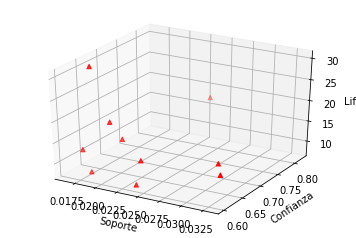

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(soporte, confianza, lift, c="r", marker='^')
ax.set_xlabel('Soporte')
ax.set_ylabel('Confianza')
ax.set_zlabel('Lift')

plt.show()

Como comentario, no entendí muy bien el algoritmo, en las diapos estaba muy simplificado, en internet salian cosas muchas mas complicadas y dificiles de entender :(